---
title: "Simulation setup for benchmarking matrix factorization methods"
author: "Saikat Banerjee"
format:
  html: default
  ipynb: default
date: "2023-07-05"
---

# About

Here, I check if the simulation benchmarking makes sense using simple examples.
The idea is to run large scale simulations using pipelines. 
Before that, I want to look at simple examples.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

from nnwmf.functions.frankwolfe import frank_wolfe_minimize
from nnwmf.functions.robustpca import RobustPCA

In [3]:
#| code-fold: false

ntrait = 4 # categories / class
ngwas  = 500 # N
nsnp   = 1000 # P
nfctr  = 20 # K

In [4]:
sample_dict = mpy_simulate.get_sample_indices(ntrait, ngwas, shuffle = False)
sample_indices = [x for _, x in sample_dict.items()]
unique_labels  = [k for k, _ in sample_dict.items()]
class_labels = [None for x in range(ngwas)]
for k, x in sample_dict.items():
    for i in x:
        class_labels[i] = k

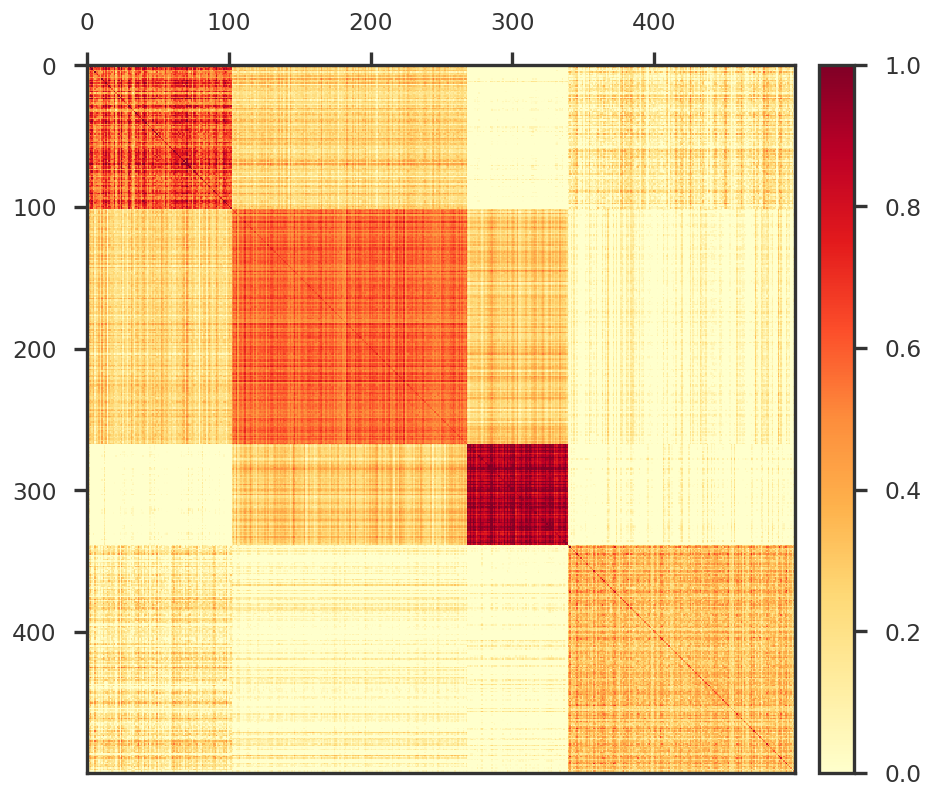

In [5]:
Y, Y_true, L, F, mean, noise_std = mpy_simulate.simulate(ngwas, nsnp, ntrait, nfctr, sample_groups = sample_indices, std = 0.5)
Y_cent = mpy_simulate.do_standardize(Y, scale = False)

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

mpy_plotfn.plot_covariance_heatmap(ax1, L)

plt.tight_layout()
plt.show()

# True components

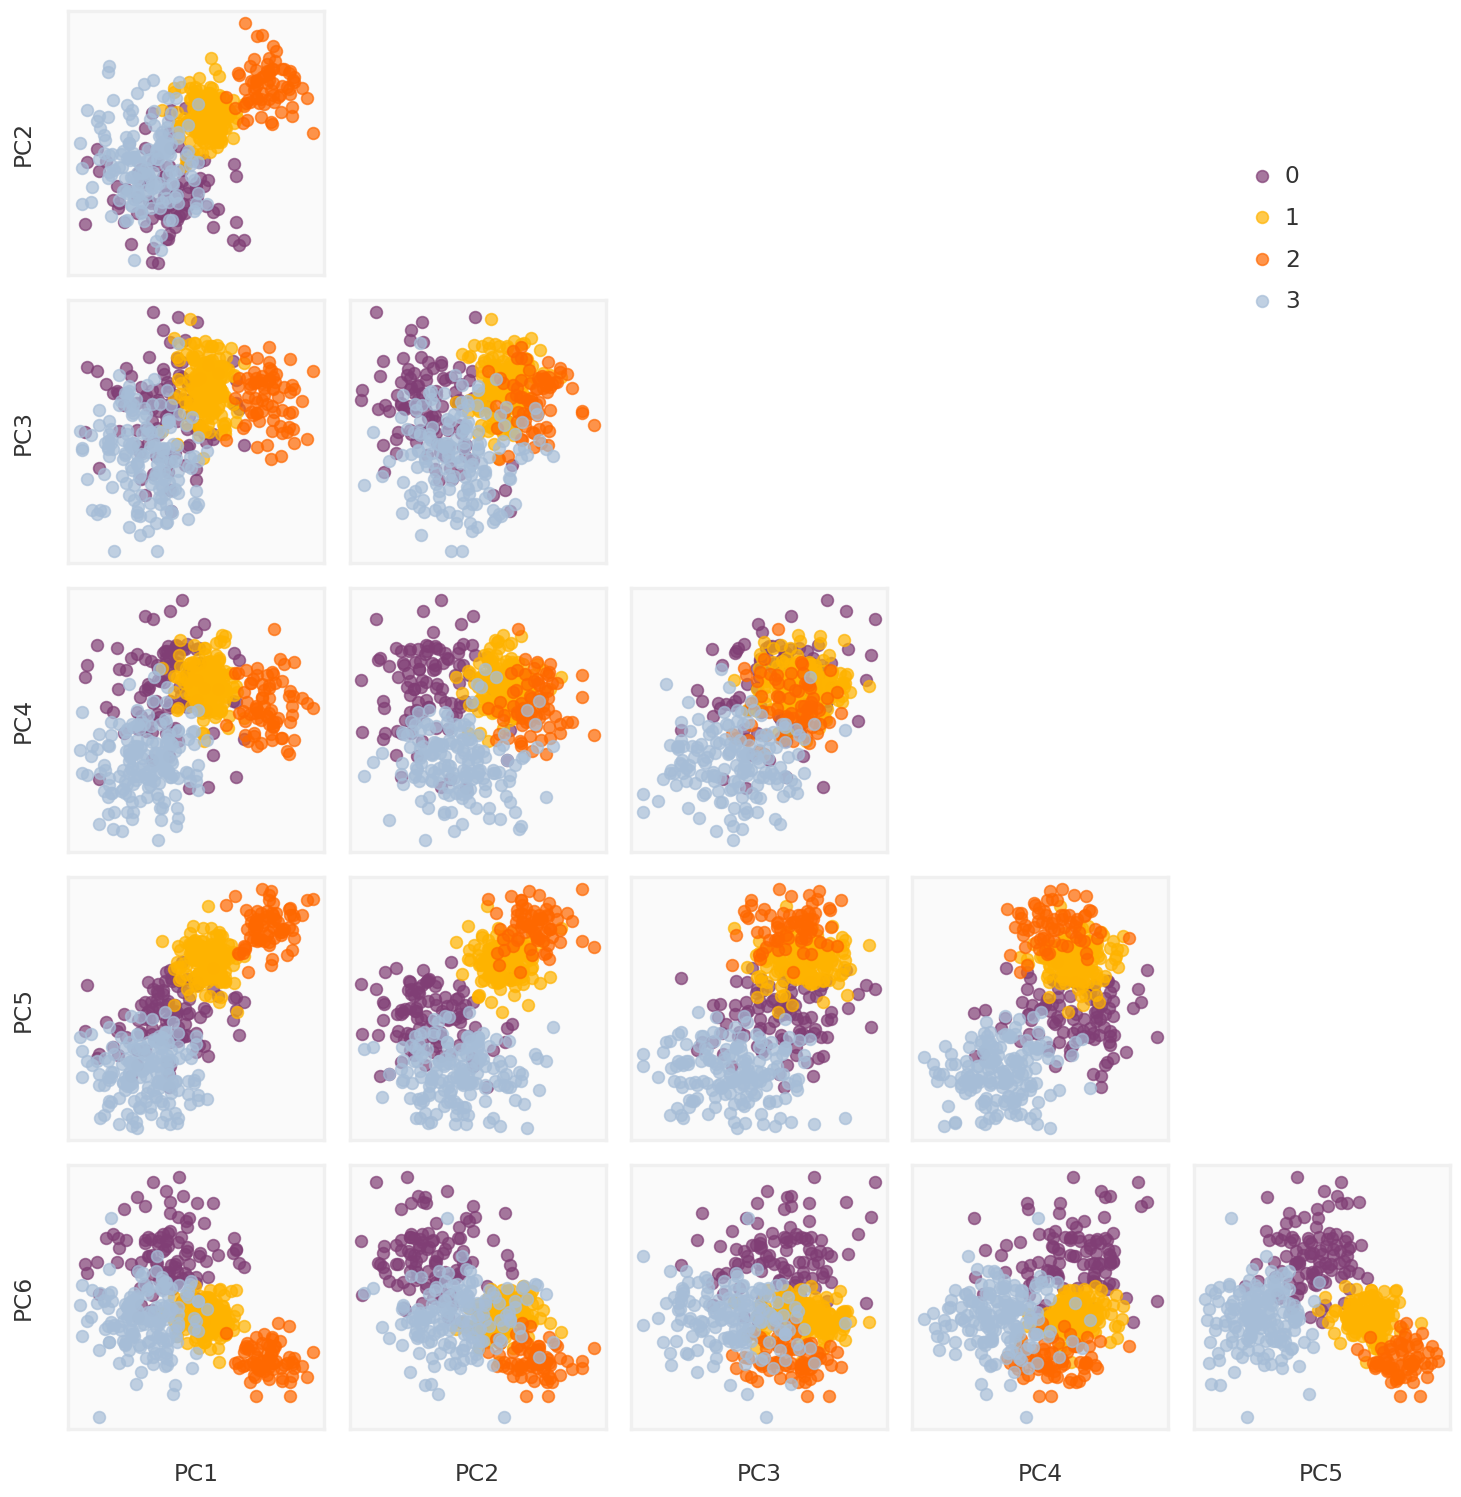

In [6]:
axmain, axs = mpy_plotfn.plot_principal_components(L, class_labels, unique_labels)
plt.show()

# Truncated SVD

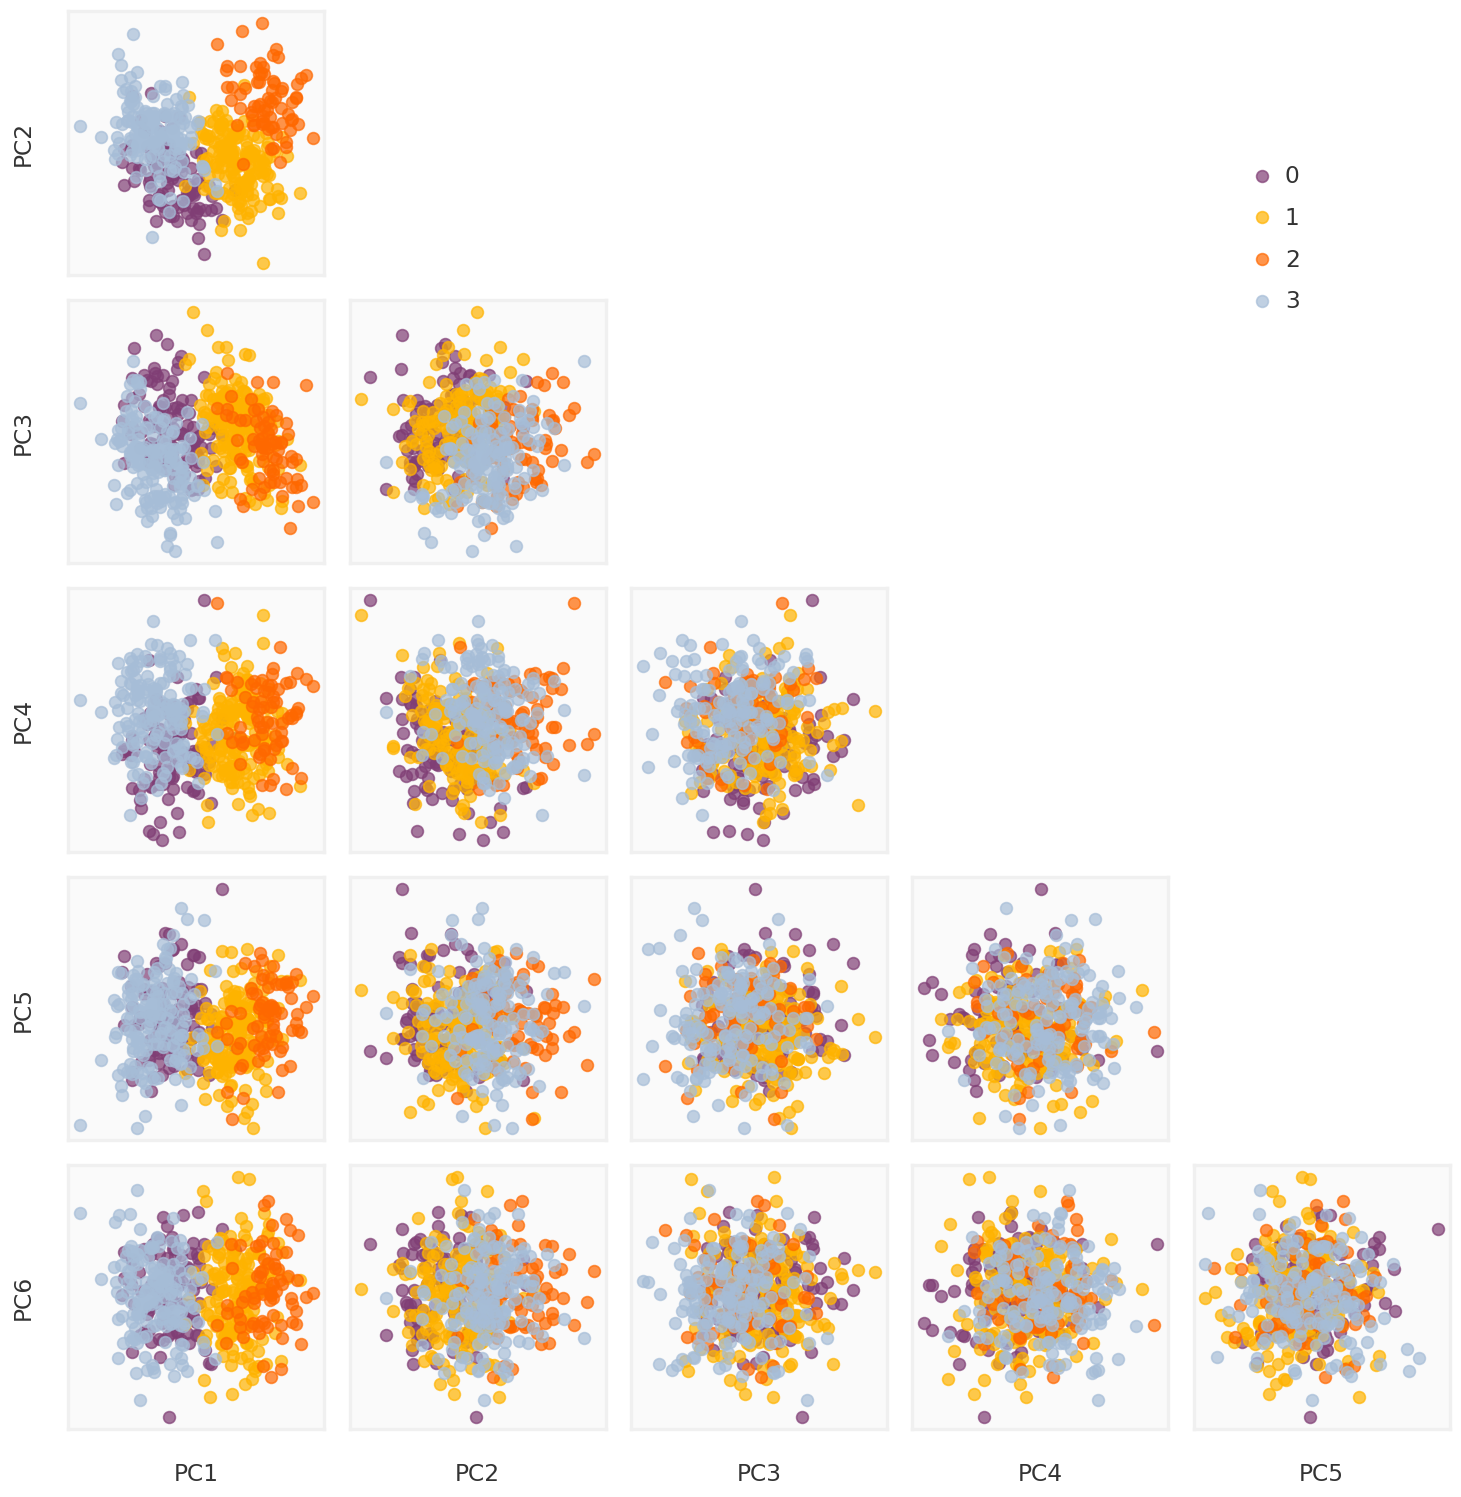

In [7]:
k = 200
U, S, Vt = np.linalg.svd(Y_cent, full_matrices=False)
pcomps_tsvd = U[:, :k] @ np.diag(S[:k])
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_tsvd, class_labels, unique_labels)
plt.show()

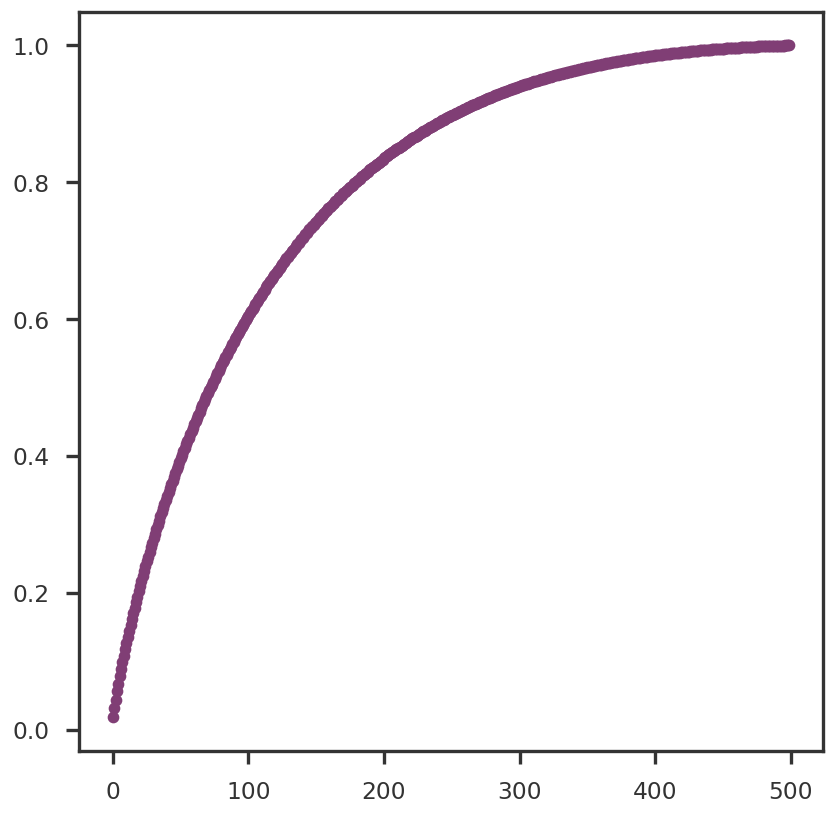

In [8]:
S2 = np.square(S)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(S.shape[0]), np.cumsum(S2 / np.sum(S2)), 'o-')
plt.show()

# Nuclear Norm Minimization using Frank-Wolfe algorithm

In [9]:
r_opt = 20.
Y_nnm, _, _, _ = frank_wolfe_minimize(Y_cent, r_opt)

Y_nnm_cent = mpy_simulate.do_standardize(Y_nnm, scale = False)
U_nnm, S_nnm, Vt_nnm = np.linalg.svd(Y_nnm_cent, full_matrices = False)
pcomps_nnm = U_nnm @ np.diag(S_nnm)

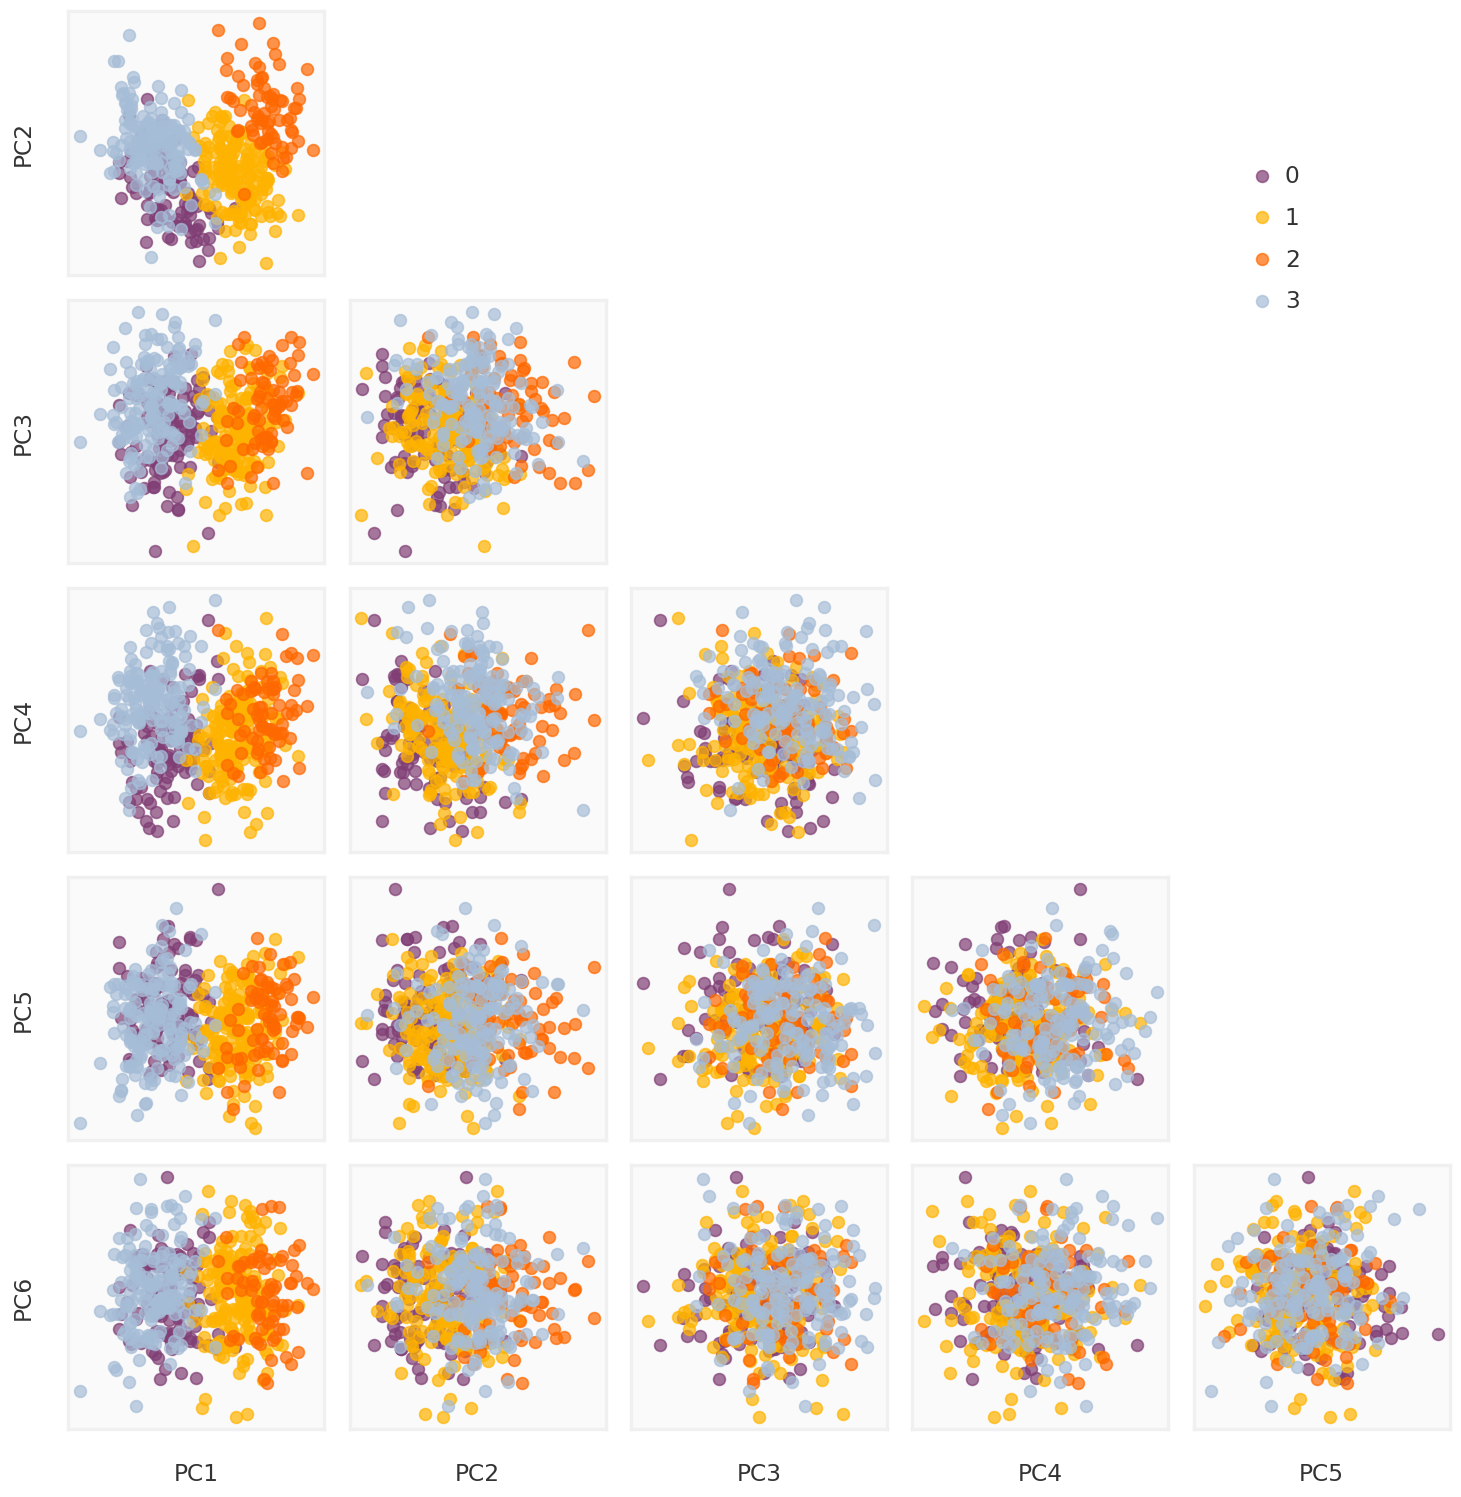

In [10]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_nnm, class_labels, unique_labels)
plt.show()

# Weighted Nuclear Norm Minimization

In [27]:
snp_weights = 1 / np.abs(noise_std)
weight = np.column_stack([snp_weights for _ in range(ngwas)]).T

Y_wnnm, _, _, _ = frank_wolfe_minimize(Y_cent, r_opt, weight = weight)

Y_wnnm_cent = mpy_simulate.do_standardize(Y_wnnm, scale = False)
U_wnnm, S_wnnm, Vt_wnnm = np.linalg.svd(Y_wnnm_cent, full_matrices = False)
pcomps_wnnm = U_wnnm @ np.diag(S_wnnm)

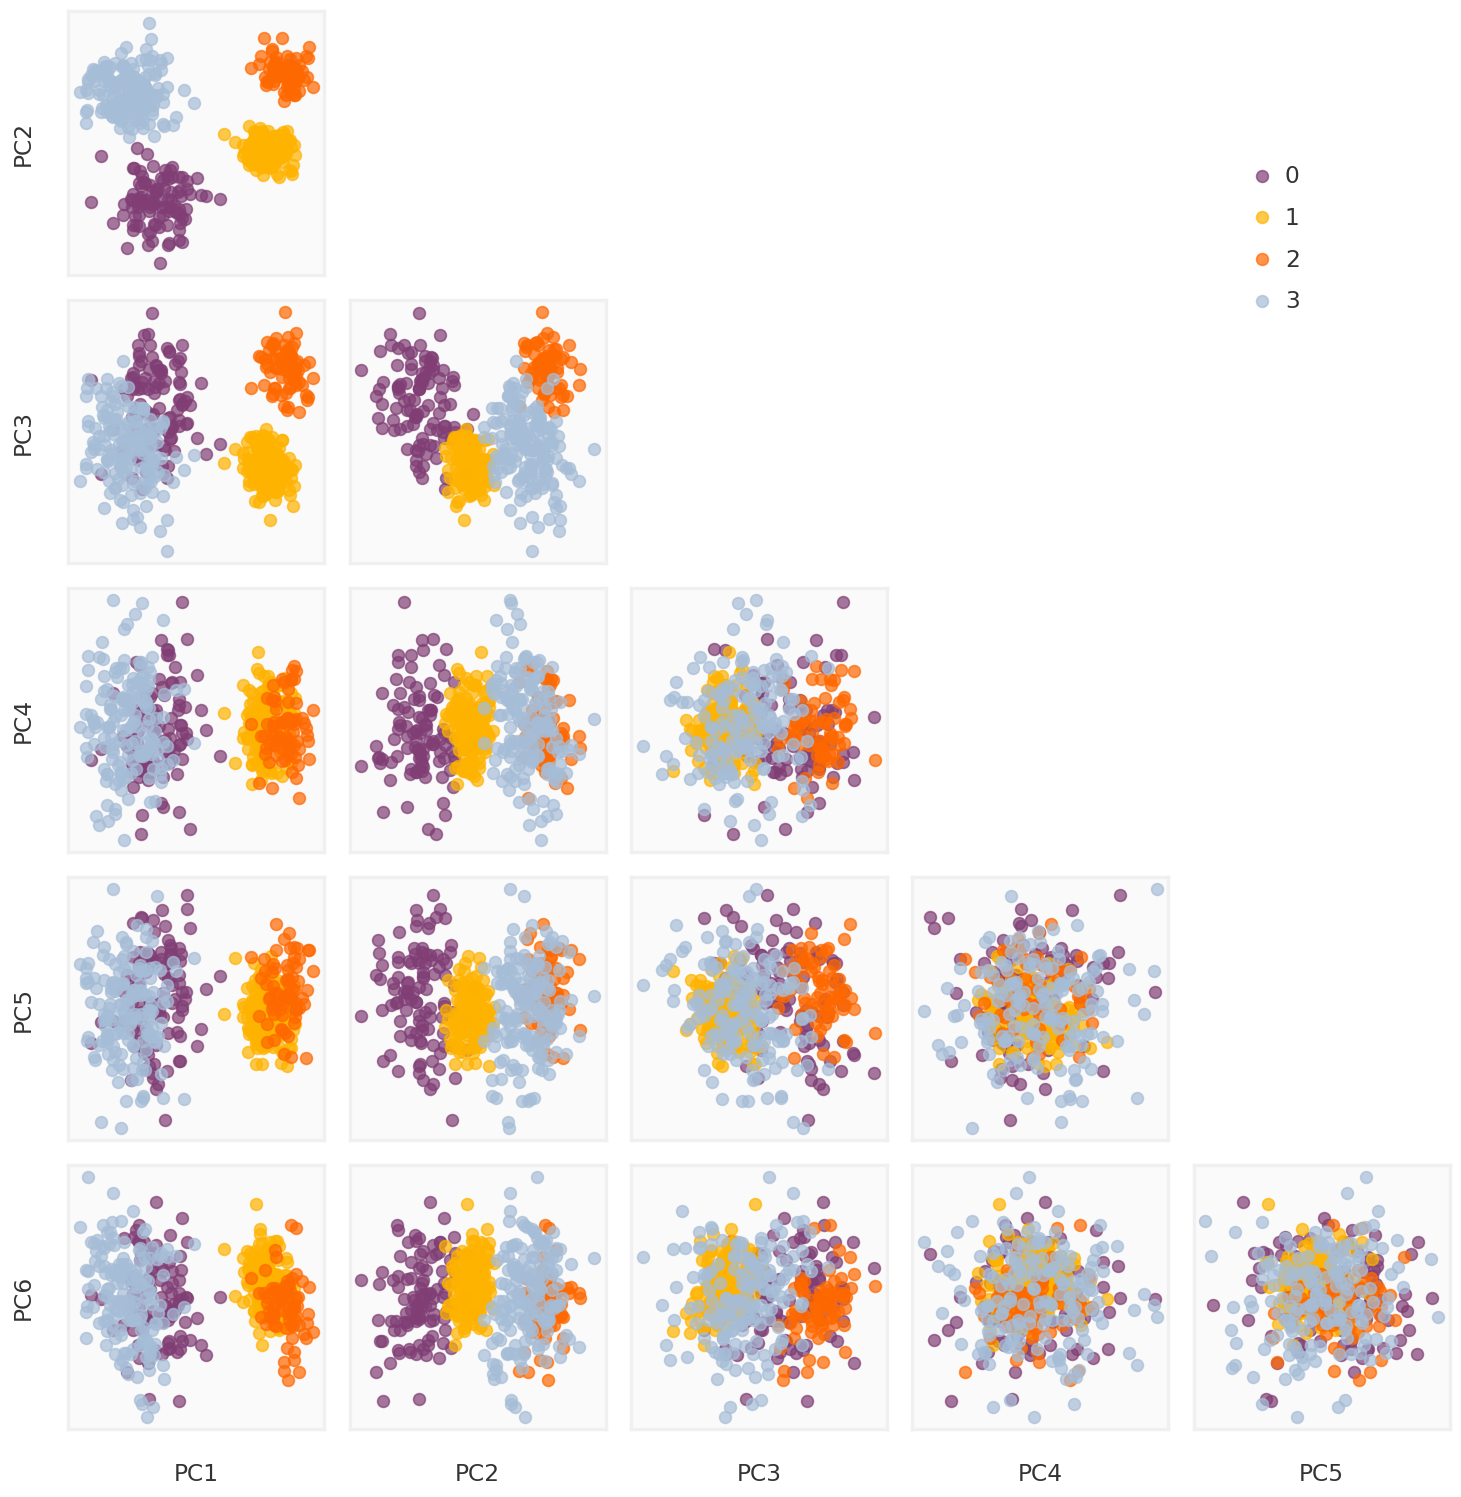

In [28]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_wnnm, class_labels, unique_labels)
plt.show()

# Robust PCA

In [11]:
rpca = RobustPCA(lmb=0.02, max_iter=1000)
L_rpca, M_rpca = rpca.fit(Y_cent)
np.linalg.matrix_rank(L_rpca)

26

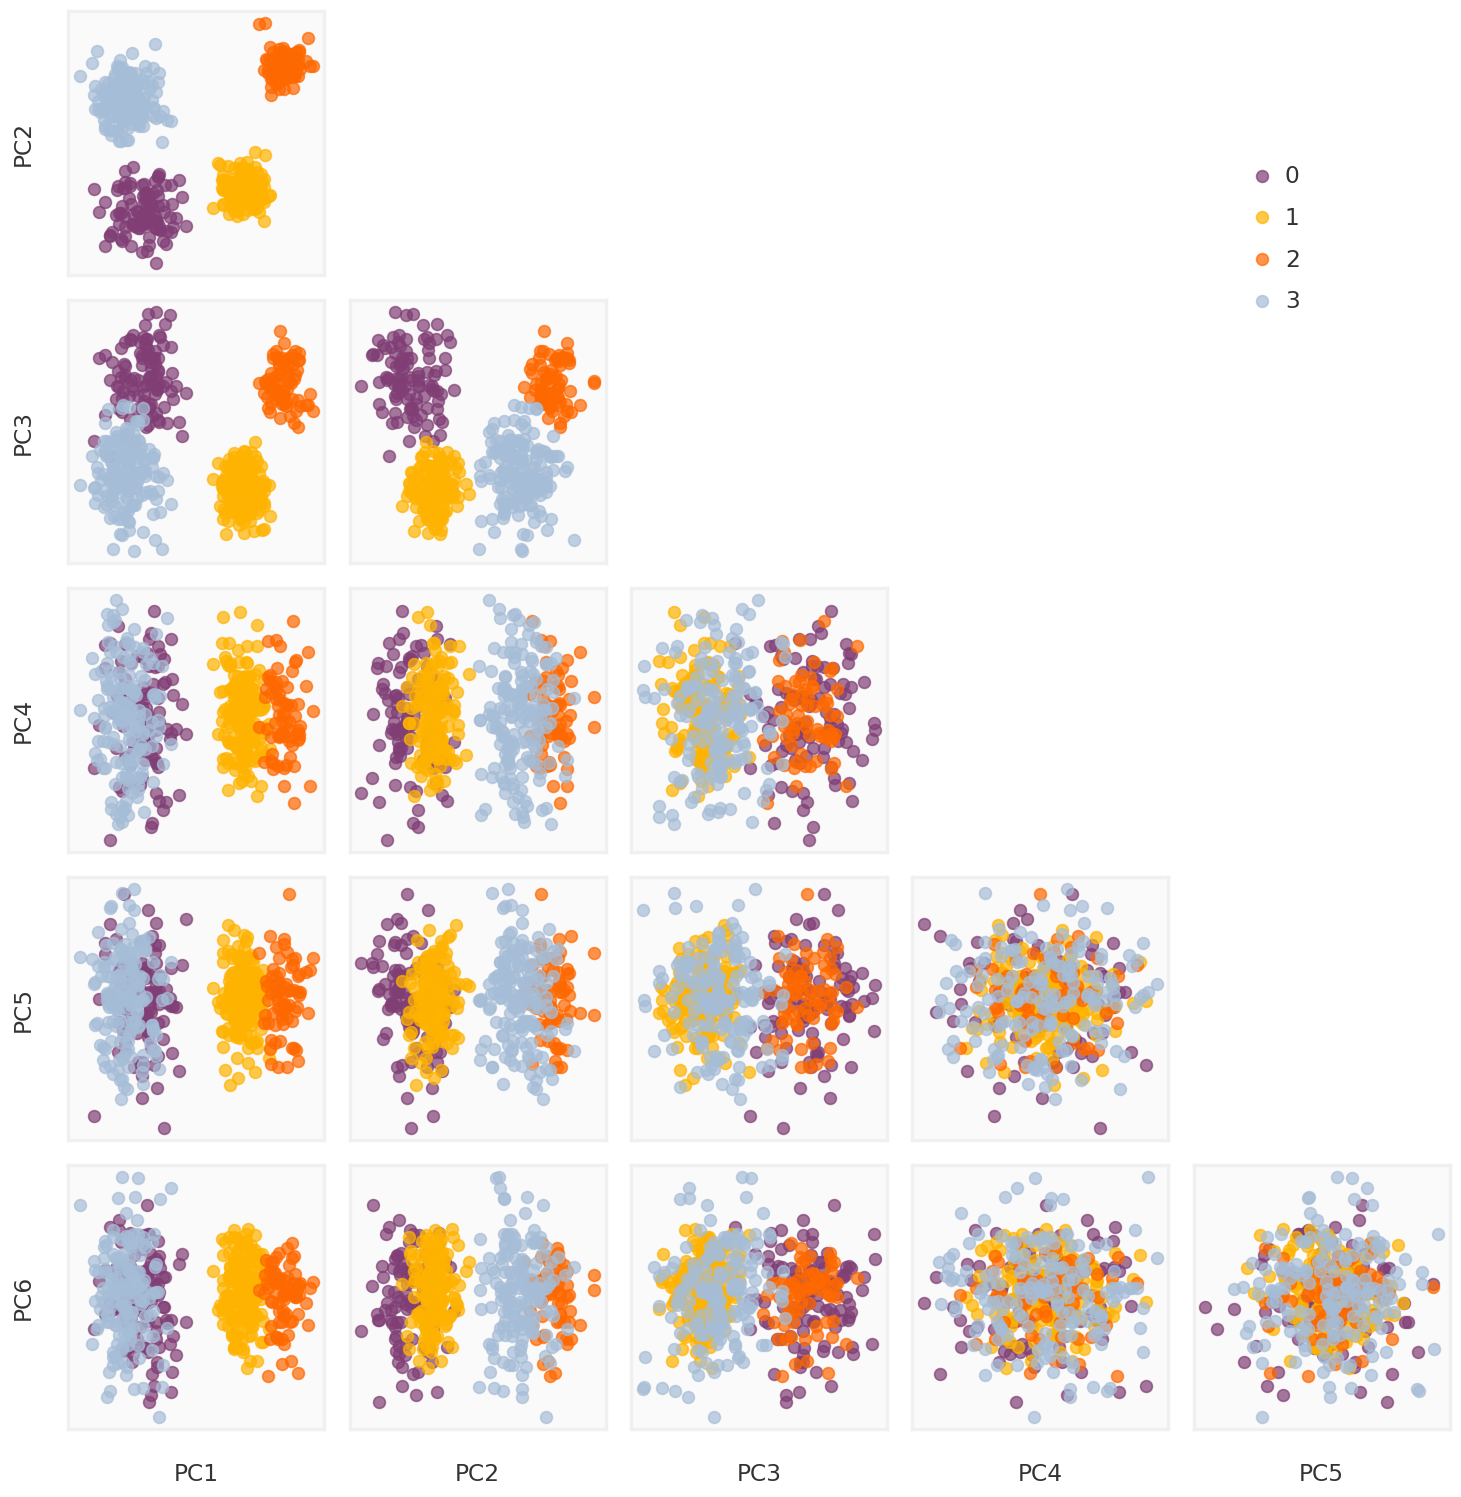

In [12]:
Y_rpca_cent = mpy_simulate.do_standardize(L_rpca, scale = False)
U_rpca, S_rpca, Vt_rpca = np.linalg.svd(Y_rpca_cent, full_matrices = False)
pcomps_rpca = U_rpca @ np.diag(S_rpca)
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_rpca, class_labels, unique_labels)
plt.show()

In [39]:
def get_rrmse(Y_pred, Y_true):
    x = np.sqrt(np.sum(np.square(Y_pred - Y_true) / np.square(Y_true)))
    return x
    
Y_true_cent = mpy_simulate.do_standardize(Y_true, scale = False)
Y_rpca_cent = mpy_simulate.do_standardize(L_rpca + M_rpca, scale = False)

rrmse_nnm = get_rrmse(Y_nnm_cent,   Y_true_cent)
rrmse_wnnm = get_rrmse(Y_wnnm_cent, Y_true_cent)
rrmse_rpca = get_rrmse(Y_rpca_cent, Y_true_cent)

print (f"{rrmse_nnm:.4f}\tNuclear Norm Minimization")
print (f"{rrmse_wnnm:.4f}\tWeighted Nuclear Norm Minimization")
print (f"{rrmse_rpca:.4f}\tRobust PCA")

60767.2074	Nuclear Norm Minimization
5028.3064	Weighted Nuclear Norm Minimization
3587828.2975	Robust PCA


In [41]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics as skmetrics

def get_adjusted_MI_score(pcomp, class_labels):
    distance_matrix = skmetrics.pairwise.pairwise_distances(pcomp, metric='euclidean')
    model = AgglomerativeClustering(n_clusters = 4, linkage = 'average', metric = 'precomputed')
    class_pred = model.fit_predict(distance_matrix)
    return skmetrics.adjusted_mutual_info_score(class_labels, class_pred)

adjusted_mi_nnm = get_adjusted_MI_score(pcomps_nnm,   class_labels)
adjusted_mi_wnnm = get_adjusted_MI_score(pcomps_wnnm, class_labels)
adjusted_mi_rpca = get_adjusted_MI_score(pcomps_rpca, class_labels)

print (f"{adjusted_mi_nnm:.4f}\tNuclear Norm Minimization")
print (f"{adjusted_mi_wnnm:.4f}\tWeighted Nuclear Norm Minimization")
print (f"{adjusted_mi_rpca:.4f}\tRobust PCA")

0.4597	Nuclear Norm Minimization
0.9844	Weighted Nuclear Norm Minimization
1.0000	Robust PCA
